# Quick CNN Training - Ultra Lightweight + Augmentation

## Overview
This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

## Features
- **5 Core Concepts**: periodicity, temporal_stability, coordination, motion_intensity, vertical_dominance
- **Data Augmentation**: Jitter, scaling, and rotation for robust training
- **Contextual Learning**: Static posture context for motion concepts
- **Optimized Architecture**: Lightweight CNN with enhanced parameters for 5 concepts


## 1. Imports and Configuration

**Purpose**: Load necessary libraries and contextual configuration for model training.

**Key Components**:
- TensorFlow/Keras for deep learning
- Scikit-learn for data preprocessing
- Contextual configuration for motion concepts


# Quick CNN Training - Ultra Lightweight + Augmentation
## Streamlined version for rapid iteration

This notebook contains only the essential components for training the ultra-lightweight CNN with augmentation and random shuffle split.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import warnings
import json
import torch
import pickle
import sys
import os
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Load contextual configuration from rule definitions
try:
    with open('../rule_based_labeling/contextual_config.json', 'r') as f:
        contextual_config = json.load(f)
    print(f"\nLoaded contextual configuration:")
    for feature, uses_context in contextual_config.items():
        print(f"  {feature}: {'Uses static posture context' if uses_context else 'Independent'}")
except FileNotFoundError:
    print("Warning: contextual_config.json not found. Using default configuration.")
    contextual_config = {
        'motion_intensity': True,
        'vertical_dominance': True,
        'periodicity': False,
        'temporal_stability': False,
        'coordination': False
    }

TensorFlow version: 2.20.0
Keras version: 3.11.3

Loaded contextual configuration:
  motion_intensity: Uses static posture context
  vertical_dominance: Uses static posture context
  periodicity: Independent
  temporal_stability: Independent
  coordination: Independent
  directional_variability: Independent
  burstiness: Independent


In [ ]:
# =============================================================================
# CONCEPT PREDICTOR INTEGRATION
# =============================================================================

# Add the pretraining directory to path
sys.path.append('../pretraining')

# Import the concept predictor
from fine_tune_concepts import PretrainedConceptPredictor

class ConceptPredictorWrapper:
    """Wrapper for the fine-tuned concept prediction model."""
    
    def __init__(self):
        self.model = None
        self.scaler = None
        self.device = torch.device('cpu')
        self._load_model()
    
    def _load_model(self):
        """Load the fine-tuned concept prediction model."""
        print("Loading fine-tuned concept predictor...")
        
        # Initialize model
        self.model = PretrainedConceptPredictor(
            pretrained_encoder_path='../pretraining/improved_pretrained_encoder.pth',
            input_dim=3,
            hidden_dim=64,
            num_concepts=5,
            freeze_encoder=True
        )
        
        # Load fine-tuned weights
        model_path = '../pretraining/best_concept_predictor.pth'
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.eval()
        self.model = self.model.to(self.device)
        
        # Load scaler
        scaler_path = '../pretraining/improved_scaler.pkl'
        with open(scaler_path, 'rb') as f:
            self.scaler = pickle.load(f)
        
        print("✓ Concept predictor loaded successfully!")
    
    def predict_concepts_from_windows(self, X_windows):
        """
        Predict concepts from pre-processed windows.
        
        Args:
            X_windows: Pre-processed windows (n_windows, window_size, 3)
            
        Returns:
            concept_predictions: Array of concept predictions (n_windows, 5)
        """
        # Convert to tensor and transpose for Conv1d
        windows_tensor = torch.FloatTensor(X_windows.transpose(0, 2, 1)).to(self.device)
        
        # Predict concepts
        with torch.no_grad():
            predictions = self.model(windows_tensor)
            predictions = predictions.cpu().numpy()
        
        return predictions
    
    def get_concept_features(self, X_windows):
        """
        Get concept predictions as additional features for your CNN.
        
        Args:
            X_windows: Pre-processed windows (n_windows, window_size, 3)
            
        Returns:
            concept_features: Concept predictions as features (n_windows, 5)
        """
        return self.predict_concepts_from_windows(X_windows)

# Initialize the concept predictor
print("Initializing concept predictor...")
concept_predictor = ConceptPredictorWrapper()


In [ ]:
# =============================================================================
# ENHANCED CNN WITH CONCEPT FEATURES
# =============================================================================

def build_enhanced_cnn_with_concepts(input_shape, n_classes_p, n_classes_t, n_classes_c, contextual_config):
    """
    Enhanced CNN that uses both raw sensor data and concept predictions.
    
    This model combines:
    1. Traditional CNN processing of sensor data
    2. Concept predictions from the fine-tuned model
    3. Contextual features
    """
    # Input layer for sensor data
    sensor_input = layers.Input(shape=input_shape, name='sensor_input')
    
    # Input layer for concept predictions
    concept_input = layers.Input(shape=(5,), name='concept_input')
    
    # CNN processing of sensor data
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(sensor_input)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Combine sensor features with concept features
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(32, activation='relu')(x)
    
    # Concatenate with concept predictions
    combined_features = layers.Concatenate()([x, concept_input])
    combined_features = layers.Dense(64, activation='relu')(combined_features)
    combined_features = layers.Dropout(0.3)(combined_features)
    
    # Static posture context
    static_context = layers.Dense(1, activation='sigmoid', name='static_context')(combined_features)
    
    # Output heads for each concept
    outputs = []
    output_names = []
    
    # Periodicity (3 classes)
    if 'periodicity' in contextual_config and contextual_config['periodicity']:
        periodicity_output = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(combined_features)
        outputs.append(periodicity_output)
        output_names.append('periodicity')
    
    # Temporal stability (3 classes)
    if 'temporal_stability' in contextual_config and contextual_config['temporal_stability']:
        temporal_output = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(combined_features)
        outputs.append(temporal_output)
        output_names.append('temporal_stability')
    
    # Coordination (3 classes)
    if 'coordination' in contextual_config and contextual_config['coordination']:
        coordination_output = layers.Dense(n_classes_c, activation='softmax', name='coordination')(combined_features)
        outputs.append(coordination_output)
        output_names.append('coordination')
    
    # Motion intensity (regression)
    if 'motion_intensity' in contextual_config and contextual_config['motion_intensity']:
        motion_intensity_output = layers.Dense(1, activation='sigmoid', name='motion_intensity')(combined_features)
        outputs.append(motion_intensity_output)
        output_names.append('motion_intensity')
    
    # Vertical dominance (regression)
    if 'vertical_dominance' in contextual_config and contextual_config['vertical_dominance']:
        vertical_dominance_output = layers.Dense(1, activation='sigmoid', name='vertical_dominance')(combined_features)
        outputs.append(vertical_dominance_output)
        output_names.append('vertical_dominance')
    
    # Add static context to outputs
    outputs.append(static_context)
    output_names.append('static_context')
    
    # Create model
    model = models.Model(inputs=[sensor_input, concept_input], outputs=outputs)
    
    print(f"Enhanced model architecture:")
    print(f"  Input 1: Sensor data {input_shape}")
    print(f"  Input 2: Concept predictions (5,)")
    print(f"  Outputs: {output_names}")
    
    return model


In [ ]:
# =============================================================================
# REPLACE MODEL BUILDING WITH ENHANCED VERSION
# =============================================================================

# This cell replaces the original model building with the enhanced version
# that includes concept features from the fine-tuned predictor

# First, we need to define all the required variables from the original notebook
# These should already exist from previous cells, but let's ensure they're defined

# Check if required variables exist, if not, we need to run the data preparation cells first
required_vars = ['X_train_aug', 'X_test', 'y_p_train_cat', 'y_t_train_cat', 'y_c_train_cat', 
                'y_mi_train', 'y_vd_train', 'y_sp_context_train_cat', 'y_p_test_cat', 
                'y_t_test_cat', 'y_c_test_cat', 'y_mi_test', 'y_vd_test', 'y_sp_context_test_cat']

missing_vars = []
for var in required_vars:
    if var not in locals():
        missing_vars.append(var)

if missing_vars:
    print(f"ERROR: Missing required variables: {missing_vars}")
    print("Please run the data preparation cells first to define these variables.")
    print("The enhanced model requires the original data preprocessing to be completed.")
else:
    print("All required variables found. Proceeding with enhanced model...")
    
    # Get concept predictions for training data
    print("Generating concept predictions for training data...")
    X_train_concepts = concept_predictor.get_concept_features(X_train_aug)
    print(f"Training concept features shape: {X_train_concepts.shape}")

    # Get concept predictions for test data  
    print("Generating concept predictions for test data...")
    X_test_concepts = concept_predictor.get_concept_features(X_test)
    print(f"Test concept features shape: {X_test_concepts.shape}")

    # Build enhanced model with concept features
    print("Building enhanced model with concept features...")
    model = build_enhanced_cnn_with_concepts(
        input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
        n_classes_p=3, n_classes_t=3, n_classes_c=3,
        contextual_config=contextual_config
    )


In [ ]:
# =============================================================================
# UPDATE TRAINING DATA PREPARATION
# =============================================================================

# Prepare training data with concept features
print("Preparing enhanced training data...")
train_inputs = [X_train_aug, X_train_concepts]
train_targets = {
    'periodicity': y_p_train_cat,
    'temporal_stability': y_t_train_cat,
    'coordination': y_c_train_cat,
    'motion_intensity': y_mi_train,
    'vertical_dominance': y_vd_train,
    'static_context': y_sp_context_train_cat
}

# Prepare validation data
val_inputs = [X_test, X_test_concepts]
val_targets = {
    'periodicity': y_p_test_cat,
    'temporal_stability': y_t_test_cat,
    'coordination': y_c_test_cat,
    'motion_intensity': y_mi_test,
    'vertical_dominance': y_vd_test,
    'static_context': y_sp_context_test_cat
}

print("Enhanced data preparation completed!")
print(f"Training inputs: Sensor data {X_train_aug.shape}, Concept features {X_train_concepts.shape}")
print(f"Validation inputs: Sensor data {X_test.shape}, Concept features {X_test_concepts.shape}")


In [ ]:
# =============================================================================
# ENHANCED MODEL COMPILATION AND TRAINING
# =============================================================================

# Compile the enhanced model
print("Compiling enhanced model...")
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'periodicity': 'categorical_crossentropy',
        'temporal_stability': 'categorical_crossentropy', 
        'coordination': 'categorical_crossentropy',
        'motion_intensity': 'mse',
        'vertical_dominance': 'mse',
        'static_context': 'binary_crossentropy'
    },
    loss_weights={
        'periodicity': 1.0,
        'temporal_stability': 1.0,
        'coordination': 1.0,
        'motion_intensity': 1.0,
        'vertical_dominance': 1.0,
        'static_context': 0.5
    },
    metrics={
        'periodicity': 'accuracy',
        'temporal_stability': 'accuracy',
        'coordination': 'accuracy',
        'motion_intensity': 'mae',
        'vertical_dominance': 'mae',
        'static_context': 'accuracy'
    }
)

print("Enhanced model compiled successfully!")
print("Model summary:")
model.summary()


In [ ]:
# =============================================================================
# ENHANCED TRAINING WITH CONCEPT FEATURES
# =============================================================================

print("Training enhanced model with concept features...")
print("=" * 60)

# Train the enhanced model
history = model.fit(
    train_inputs, train_targets,
    validation_data=(val_inputs, val_targets),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5)
    ]
)

print("Enhanced training completed!")
print("=" * 60)


In [ ]:
# =============================================================================
# ENHANCED EVALUATION WITH CONCEPT FEATURES
# =============================================================================

print("Evaluating enhanced model with concept features...")
print("=" * 60)

# Evaluate the enhanced model
results = model.evaluate(val_inputs, val_targets, verbose=0)

print("Enhanced Model Results:")
print("=" * 40)
for i, metric in enumerate(model.metrics_names):
    print(f"{metric}: {results[i]:.4f}")

# Get predictions from enhanced model
print("\nGenerating enhanced predictions...")
enhanced_predictions = model.predict(val_inputs, verbose=0)

# Extract predictions for each concept
periodicity_pred = np.argmax(enhanced_predictions[0], axis=1)
temporal_stability_pred = np.argmax(enhanced_predictions[1], axis=1)
coordination_pred = np.argmax(enhanced_predictions[2], axis=1)
motion_intensity_pred = enhanced_predictions[3].flatten()
vertical_dominance_pred = enhanced_predictions[4].flatten()

print("Enhanced model evaluation completed!")
print("=" * 60)


# =============================================================================
# INSTRUCTIONS FOR USING ENHANCED MODEL
# =============================================================================

## **How to Use the Enhanced Model with Concept Features**

### **Prerequisites:**
1. **Run all data preparation cells first** (cells 1-3 in the original notebook)
2. **Ensure all variables are defined** before running enhanced cells
3. **The enhanced model requires** the original data preprocessing to be completed

### **Required Variables (must be defined first):**
- `X_train_aug`, `X_test` - Preprocessed sensor data
- `y_p_train_cat`, `y_t_train_cat`, `y_c_train_cat` - Categorical concept labels
- `y_mi_train`, `y_vd_train` - Continuous concept labels  
- `y_sp_context_train_cat` - Static posture context
- `y_p_test_cat`, `y_t_test_cat`, `y_c_test_cat` - Test categorical labels
- `y_mi_test`, `y_vd_test` - Test continuous labels
- `y_sp_context_test_cat` - Test static posture context

### **Enhanced Model Features:**
- **Dual Input**: Sensor data + Concept predictions
- **Transfer Learning**: Uses pretrained concept representations
- **Enhanced Performance**: Better feature representation
- **Backward Compatible**: Works with existing preprocessing

### **Usage Steps:**
1. **Run original data preparation** (cells 1-3)
2. **Run concept predictor integration** (cell 4)
3. **Run enhanced architecture** (cell 5)
4. **Run enhanced model building** (cell 6)
5. **Run enhanced training** (cells 7-10)

### **Expected Output:**
- Enhanced model with concept features
- Improved performance metrics
- Better concept prediction accuracy
- Transfer learning benefits


## 2. Data Loading and Discretization

**Purpose**: Load sensor data and convert continuous concept values to discrete categories.

**Process**:
- Load raw sensor data and window labels
- Convert continuous values to discrete (0.0, 0.5, 1.0) for all concepts
- Apply discretization rules for motion_intensity and vertical_dominance


In [24]:
# Load data - CHANGE THESE PATHS AS NEEDED
df_sensor = pd.read_csv('../rule_based_labeling/raw_with_features.csv')
df_windows = pd.read_csv('../rule_based_labeling/window_with_features.csv') 

print(f"Sensor data: {len(df_sensor)} readings")
print(f"Manual labels: {len(df_windows)} windows")
print(f"\nLabeled windows:")
print(df_windows.head())

# Check available concepts - ORIGINAL 5-CONCEPT MODEL
concept_columns = ['periodicity', 'temporal_stability', 'coordination', 'motion_intensity', 'vertical_dominance', 'static_posture']
print(f"\nAvailable concepts: {concept_columns}")

# Debug: Check original values BEFORE discretization
print(f"\n=== BEFORE DISCRETIZATION ===")
print(f"Original motion_intensity range: {df_windows['motion_intensity'].min():.4f} to {df_windows['motion_intensity'].max():.4f}")
print(f"Original vertical_dominance range: {df_windows['vertical_dominance'].min():.4f} to {df_windows['vertical_dominance'].max():.4f}")

# Convert rule-based concepts to discrete labels (0, 0.5, 1.0)
print(f"\n=== APPLYING DISCRETIZATION ===")

# Motion Intensity: Convert continuous values to discrete
# Low (0.0): < 0.35, Medium (0.5): 0.35-0.45, High (1.0): > 0.45
df_windows['motion_intensity'] = pd.cut(
    df_windows['motion_intensity'], 
    bins=[-np.inf, 0.35, 0.45, np.inf], 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Vertical Dominance: Convert continuous values to discrete  
# Low (0.0): < 0.2, Medium (0.5): 0.2-0.35, High (1.0): > 0.35
df_windows['vertical_dominance'] = pd.cut(
    df_windows['vertical_dominance'], 
    bins=[-np.inf, 0.2, 0.35, np.inf], 
    labels=[0.0, 0.5, 1.0]
).astype(float)

# Static Posture: Already binary (0.0 or 1.0), keep as is
# No change needed for static_posture

# Note: Removed directional_variability and burstiness to restore original 5-concept model

# Debug: Check discretized values
print(f"\n=== AFTER DISCRETIZATION ===")
print(f"Discretized motion_intensity: {df_windows['motion_intensity'].value_counts().sort_index()}")
print(f"Discretized vertical_dominance: {df_windows['vertical_dominance'].value_counts().sort_index()}")
print(f"Discretized directional_variability: {df_windows['directional_variability'].value_counts().sort_index()}")
print(f"Discretized burstiness: {df_windows['burstiness'].value_counts().sort_index()}")

# Final check: Show all concept distributions
print(f"\n=== FINAL CONCEPT DISTRIBUTIONS ===")
for concept in concept_columns:
    if concept in df_windows.columns:
        values = df_windows[concept].value_counts().sort_index()
        print(f"  {concept}: {dict(values)}")

print(f"\nDiscretization completed successfully!")

Sensor data: 8802 readings
Manual labels: 150 windows

Labeled windows:
   window_idx  user activity  start_time  end_time  periodicity  \
0           0     3  Walking      957.75    960.75          1.0   
1           1     3  Walking       42.00     45.00          1.0   
2           2     3  Walking      871.50    874.50          0.5   
3           3     3  Walking       63.00     66.00          1.0   
4           4     3  Jogging      117.75    120.75          1.0   

   temporal_stability  coordination  motion_intensity  vertical_dominance  \
0                 0.5           0.5          0.316815            0.221105   
1                 0.5           0.5          0.302850            0.291116   
2                 0.5           0.5          0.303036            0.181147   
3                 0.5           0.5          0.313779            0.305797   
4                 0.5           0.5          0.408648            0.262989   

   static_posture  directional_variability  burstiness  
0    

## 3. Window Extraction Functions

**Purpose**: Extract sensor data windows with robust time matching and error handling.

**Functions**:
- `extract_window_robust()`: Extract single window with time tolerance
- `extract_windows_robust()`: Extract all windows for 7 concepts
- Handles missing data and time mismatches gracefully


In [25]:
def extract_window_robust(df_sensor, window_row, time_tolerance=0.5):
    """
    Extract sensor data with time tolerance to handle mismatches.
    """
    user = window_row['user']
    activity = window_row['activity']
    start_time = window_row['start_time']
    end_time = window_row['end_time']
    
    # Get data for this user/activity
    user_activity_data = df_sensor[(df_sensor['user'] == user) & 
                                  (df_sensor['activity'] == activity)].copy()
    
    if len(user_activity_data) == 0:
        return None
    
    # Find data within time window with tolerance
    mask = ((user_activity_data['time_s'] >= start_time - time_tolerance) & 
            (user_activity_data['time_s'] <= end_time + time_tolerance))
    
    window_data = user_activity_data[mask]
    
    if len(window_data) < 10:  # Need minimum samples
        return None
    
    # Extract sensor readings
    sensor_data = window_data[['x-axis', 'y-axis', 'z-axis']].values
    
    # Pad or truncate to fixed length (e.g., 100 samples)
    target_length = 100
    if len(sensor_data) > target_length:
        # Randomly sample if too long
        indices = np.random.choice(len(sensor_data), target_length, replace=False)
        sensor_data = sensor_data[indices]
    elif len(sensor_data) < target_length:
        # Pad with last value if too short
        padding = np.tile(sensor_data[-1:], (target_length - len(sensor_data), 1))
        sensor_data = np.vstack([sensor_data, padding])
    
    return sensor_data

def extract_windows_robust(df_sensor, df_windows):
    """
    Extract all windows with robust time matching for 5 concepts (original model).
    """
    X = []
    y_p = []  # periodicity
    y_t = []  # temporal_stability
    y_c = []  # coordination
    y_mi = [] # motion_intensity
    y_vd = [] # vertical_dominance
    y_sp = [] # static_posture
    
    for _, window_row in df_windows.iterrows():
        window_data = extract_window_robust(df_sensor, window_row)
        if window_data is not None:
            X.append(window_data)
            y_p.append(window_row['periodicity'])
            y_t.append(window_row['temporal_stability'])
            y_c.append(window_row['coordination'])
            y_mi.append(window_row['motion_intensity'])
            y_vd.append(window_row['vertical_dominance'])
            y_sp.append(window_row['static_posture'])
    
    return np.array(X), np.array(y_p), np.array(y_t), np.array(y_c), np.array(y_mi), np.array(y_vd), np.array(y_sp)

## 4. Data Augmentation Functions

**Purpose**: Create augmented versions of the dataset to improve model robustness.

**Augmentation Types**:
- **Jitter**: Add Gaussian noise to simulate sensor imperfections
- **Scaling**: Scale magnitude to simulate different movement intensities  
- **Rotation**: Rotate 3D data to simulate different phone orientations
- **Factor**: 10x augmentation multiplier for robust training


In [26]:
def augment_jitter(data, sigma=0.05):
    """Add random Gaussian noise to simulate sensor imperfections"""
    return data + np.random.normal(0, sigma, data.shape)

def augment_scaling(data, sigma=0.1):
    """Scale magnitude to simulate different movement intensities"""
    # Handle different data shapes
    if len(data.shape) == 3:
        factor = np.random.normal(1.0, sigma, (data.shape[0], 1, data.shape[2]))
    elif len(data.shape) == 2:
        factor = np.random.normal(1.0, sigma, (data.shape[0], data.shape[1]))
    else:
        factor = np.random.normal(1.0, sigma, data.shape)
    return data * factor

def augment_rotation(data):
    """Rotate 3D data to simulate different phone orientations"""
    angle = np.random.uniform(-np.pi/6, np.pi/6)  # ±30 degrees
    cos_a, sin_a = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([
        [cos_a, -sin_a, 0],
        [sin_a, cos_a, 0],
        [0, 0, 1]
    ])
    return np.dot(data, rotation_matrix.T)

def augment_dataset(X, y_p, y_t, y_c, y_mi, y_vd, y_sp, factor=10):
    """
    Create augmented versions of the dataset for 5 concepts (original model).
    
    Args:
        X: Original data (n_samples, timesteps, 3)
        y_p, y_t, y_c, y_mi, y_vd, y_sp: Labels for five concepts
        factor: Augmentation multiplier (10 = 10x more data)
    
    Returns:
        Augmented dataset with (factor+1) × original size
    """
    n_original = len(X)
    n_augmented = n_original * factor
    
    # Initialize augmented arrays
    X_aug = np.zeros((n_augmented, X.shape[1], X.shape[2]))
    y_p_aug = np.zeros(n_augmented)
    y_t_aug = np.zeros(n_augmented)
    y_c_aug = np.zeros(n_augmented)
    y_mi_aug = np.zeros(n_augmented)
    y_vd_aug = np.zeros(n_augmented)
    y_sp_aug = np.zeros(n_augmented)
    
    for i in range(n_augmented):
        # Randomly select original sample
        idx = np.random.randint(0, n_original)
        
        # Apply random augmentation
        aug_type = np.random.choice(['jitter', 'scaling', 'rotation', 'none'])
        
        if aug_type == 'jitter':
            X_aug[i] = augment_jitter(X[idx])
        elif aug_type == 'scaling':
            X_aug[i] = augment_scaling(X[idx])
        elif aug_type == 'rotation':
            X_aug[i] = augment_rotation(X[idx])
        else:  # none
            X_aug[i] = X[idx]
        
        # Copy labels
        y_p_aug[i] = y_p[idx]
        y_t_aug[i] = y_t[idx]
        y_c_aug[i] = y_c[idx]
        y_mi_aug[i] = y_mi[idx]
        y_vd_aug[i] = y_vd[idx]
        y_sp_aug[i] = y_sp[idx]
    
    # Combine original and augmented data
    X_combined = np.vstack([X, X_aug])
    y_p_combined = np.concatenate([y_p, y_p_aug])
    y_t_combined = np.concatenate([y_t, y_t_aug])
    y_c_combined = np.concatenate([y_c, y_c_aug])
    y_mi_combined = np.concatenate([y_mi, y_mi_aug])
    y_vd_combined = np.concatenate([y_vd, y_vd_aug])
    y_sp_combined = np.concatenate([y_sp, y_sp_aug])
    
    return X_combined, y_p_combined, y_t_combined, y_c_combined, y_mi_combined, y_vd_combined, y_sp_combined

## 5. Model Architecture Definition

**Purpose**: Define the optimized CNN architecture for 7 concepts.

**Architecture**:
- **2 Conv1D layers** (16 filters each) with Batch Normalization
- **Global Average Pooling** for dimensionality reduction
- **Dropout (0.4)** for regularization
- **Contextual Learning**: Static posture context for motion concepts
- **Multi-output heads** for each concept


In [27]:
def build_optimized_cnn(input_shape, n_classes_p, n_classes_t, n_classes_c, contextual_config):
    """
    Optimized CNN using best parameters from grid search for 5 concepts (original model):
    - conv_filters_1: 16, conv_filters_2: 16
    - dropout_rate: 0.4
    - learning_rate: 0.001 (will be set in compile)
    - batch_size: 32 (will be set in fit)
    - Motion intensity uses continuous output (regression)
    - Static posture used contextually based on contextual_config
    """
    input_layer = layers.Input(shape=input_shape)
    
    # Conv layer 1 (original: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    # Conv layer 2 (original: 16 filters)
    x = layers.Conv1D(16, 3, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    
    # Dropout (original: 0.4)
    x = layers.Dropout(0.4)(x)
    
    # Static posture context (binary feature)
    static_context = layers.Dense(1, activation='sigmoid', name='static_context')(x)
    
    # Output heads for each concept - use contextual configuration
    outputs = []
    output_names = []
    
    # Independent concepts (don't use static context)
    periodicity = layers.Dense(n_classes_p, activation='softmax', name='periodicity')(x)
    temporal_stability = layers.Dense(n_classes_t, activation='softmax', name='temporal_stability')(x)
    coordination = layers.Dense(n_classes_c, activation='softmax', name='coordination')(x)
    
    outputs.extend([periodicity, temporal_stability, coordination])
    output_names.extend(['periodicity', 'temporal_stability', 'coordination'])
    
    # Motion intensity with continuous output (regression)
    if contextual_config.get('motion_intensity', False):
        motion_intensity_input = layers.Concatenate()([x, static_context])
        motion_intensity = layers.Dense(1, activation='sigmoid', name='motion_intensity')(motion_intensity_input)
    else:
        motion_intensity = layers.Dense(1, activation='sigmoid', name='motion_intensity')(x)
    
    # Vertical dominance with continuous output (regression)
    if contextual_config.get('vertical_dominance', False):
        vertical_dominance_input = layers.Concatenate()([x, static_context])
        vertical_dominance = layers.Dense(1, activation='sigmoid', name='vertical_dominance')(vertical_dominance_input)
    else:
        vertical_dominance = layers.Dense(1, activation='sigmoid', name='vertical_dominance')(x)
    
    outputs.extend([motion_intensity, vertical_dominance])
    output_names.extend(['motion_intensity', 'vertical_dominance'])
    
    # Add static context output
    outputs.append(static_context)
    output_names.append('static_context')
    
    model = models.Model(inputs=input_layer, outputs=outputs)
    
    print(f"Model architecture:")
    print(f"  Classification concepts: periodicity, temporal_stability, coordination")
    print(f"  Regression concepts: motion_intensity, vertical_dominance (continuous 0-1)")
    print(f"  Contextual concepts: {[name for name, uses_context in contextual_config.items() if uses_context]}")
    print(f"  Total concepts: 5 (original model)")
    
    return model


## 6. Data Extraction

**Purpose**: Extract sensor windows for all 7 concepts with robust error handling.

**Output**: 
- X: Sensor data (n_windows, timesteps, 3)
- y_p, y_t, y_c, y_mi, y_vd, y_dv, y_b, y_sp: Labels for 7 concepts + static context


In [28]:
# Extract windows
print("Extracting windows...")
X, y_p, y_t, y_c, y_mi, y_vd, y_sp = extract_windows_robust(df_sensor, df_windows)

print(f"Extracted {len(X)} windows")
print(f"Window shape: {X.shape}")
print(f"Label distributions:")
print(f"  Periodicity: {np.bincount(y_p.astype(int))}")
print(f"  Temporal Stability: {np.bincount(y_t.astype(int))}")
print(f"  Coordination: {np.bincount(y_c.astype(int))}")
print(f"  Motion Intensity: {np.bincount(y_mi.astype(int))}")
print(f"  Vertical Dominance: {np.bincount(y_vd.astype(int))}")
print(f"  Static Posture: {np.bincount(y_sp.astype(int))}")

Extracting windows...
Extracted 150 windows
Window shape: (150, 100, 3)
Label distributions:
  Periodicity: [125  25]
  Temporal Stability: [99 51]
  Coordination: [80 70]
  Motion Intensity: [148   2]
  Vertical Dominance: [137  13]
  Static Posture: [147   3]


## 7. Train/Test Split

**Purpose**: Split data into training and testing sets with proper stratification.

**Split**: 75% training, 25% testing
**Static Context**: Convert static posture to binary context labels


In [29]:
# Random shuffle split (75% train, 25% test)
print("Splitting data...")
X_train, X_test, y_p_train, y_p_test, y_t_train, y_t_test, y_c_train, y_c_test, y_mi_train, y_mi_test, y_vd_train, y_vd_test, y_sp_train, y_sp_test = train_test_split(
    X, y_p, y_t, y_c, y_mi, y_vd, y_sp, test_size=0.25, random_state=42, stratify=None
)

# Convert static posture to binary context (0.0 -> 0, 1.0 -> 1)
y_sp_context_train = (y_sp_train > 0).astype(int)
y_sp_context_test = (y_sp_test > 0).astype(int)

print(f"Train: {len(X_train)} windows")
print(f"Test: {len(X_test)} windows")
print(f"Static context train: {np.bincount(y_sp_context_train)}")
print(f"Static context test: {np.bincount(y_sp_context_test)}")

Splitting data...
Train: 112 windows
Test: 38 windows
Static context train: [110   2]
Static context test: [37  1]


## 8. Data Augmentation

**Purpose**: Apply augmentation to training data to increase dataset size and robustness.

**Process**:
- Apply jitter, scaling, and rotation augmentations
- 10x augmentation factor (1,232 total training samples)
- Convert static posture to binary context for augmented data


In [30]:
# Apply augmentation
print("Augmenting training data...")
X_train_aug, y_p_train_aug, y_t_train_aug, y_c_train_aug, y_mi_train_aug, y_vd_train_aug, y_sp_train_aug = augment_dataset(
    X_train, y_p_train, y_t_train, y_c_train, y_mi_train, y_vd_train, y_sp_train, factor=20
)

# Convert static posture to binary context for augmented data
y_sp_context_train_aug = (y_sp_train_aug > 0).astype(int)

print(f"Original train: {len(X_train)} windows")
print(f"Augmented train: {len(X_train_aug)} windows")
print(f"Augmentation factor: {len(X_train_aug) / len(X_train):.1f}x")
print(f"Static context train aug: {np.bincount(y_sp_context_train_aug)}")

Augmenting training data...
Original train: 112 windows
Augmented train: 2352 windows
Augmentation factor: 21.0x
Static context train aug: [2315   37]


## 9. Label Conversion to Categorical

**Purpose**: Convert discrete labels to categorical format for multi-class classification.

**Process**:
- Convert all concept labels to 3-class categorical format
- Static context remains as binary (0 or 1)
- Prepare labels for model training


In [31]:
# Convert labels to categorical
y_p_train_cat = to_categorical(y_p_train_aug * 2, num_classes=3)
y_t_train_cat = to_categorical(y_t_train_aug * 2, num_classes=3)
y_c_train_cat = to_categorical(y_c_train_aug * 2, num_classes=3)
y_mi_train_cat = to_categorical(y_mi_train_aug * 2, num_classes=3)
y_vd_train_cat = to_categorical(y_vd_train_aug * 2, num_classes=3)

y_p_test_cat = to_categorical(y_p_test * 2, num_classes=3)
y_t_test_cat = to_categorical(y_t_test * 2, num_classes=3)
y_c_test_cat = to_categorical(y_c_test * 2, num_classes=3)
y_mi_test_cat = to_categorical(y_mi_test * 2, num_classes=3)
y_vd_test_cat = to_categorical(y_vd_test * 2, num_classes=3)

# Static context is already binary (0 or 1), no need for categorical conversion
y_sp_context_train_cat = y_sp_context_train_aug.astype(float)
y_sp_context_test_cat = y_sp_context_test.astype(float)

print("Labels converted to categorical format")
print(f"Static context train shape: {y_sp_context_train_cat.shape}")
print(f"Static context test shape: {y_sp_context_test_cat.shape}")

Labels converted to categorical format
Static context train shape: (2352,)
Static context test shape: (38,)


## 10. Model Building and Compilation

**Purpose**: Build and compile the CNN model for 7 concepts.

**Configuration**:
- **Optimizer**: Adam (learning_rate=0.001)
- **Loss Functions**: Categorical crossentropy for concepts, binary crossentropy for static context
- **Loss Weights**: Balanced weights for all concepts
- **Metrics**: Accuracy for all outputs


In [32]:
# Updated model compilation for continuous motion intensity
print("Updating model compilation for continuous motion intensity...")

# Rebuild model with updated architecture (both motion concepts now continuous)
model = build_optimized_cnn(
    input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
    n_classes_p=3, n_classes_t=3, n_classes_c=3,
    contextual_config=contextual_config
)

# Compile with mixed loss functions (classification + regression)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={
        'periodicity': 'categorical_crossentropy',
        'temporal_stability': 'categorical_crossentropy',
        'coordination': 'categorical_crossentropy',
        'motion_intensity': 'mse',  # Mean squared error for regression
        'vertical_dominance': 'mse',  # Mean squared error for regression
        'static_context': 'binary_crossentropy',
    },
    loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0, 'motion_intensity': 1.0, 'vertical_dominance': 1.0, 'static_context': 0.5},
    metrics={
        'periodicity': ['accuracy'],
        'temporal_stability': ['accuracy'],
        'coordination': ['accuracy'],
        'motion_intensity': ['mae'],  # Mean absolute error for regression
        'vertical_dominance': ['mae'],  # Mean absolute error for regression
        'static_context': ['accuracy'],
    }
)

print(f"Model parameters: {model.count_params():,}")
print("Model compiled with mixed loss functions (classification + regression)")


Updating model compilation for continuous motion intensity...
Model architecture:
  Classification concepts: periodicity, temporal_stability, coordination
  Regression concepts: motion_intensity, vertical_dominance (continuous 0-1)
  Contextual concepts: ['motion_intensity', 'vertical_dominance']
  Total concepts: 5 (original model)
Model parameters: 1,278
Model compiled with mixed loss functions (classification + regression)


In [33]:
# Prepare continuous motion concept labels
print("Preparing continuous motion concept labels...")

# Motion intensity should be continuous (0.0 to 1.0), not categorical
y_mi_train_continuous = y_mi_train_aug.astype(float)  # Keep as continuous values
y_mi_test_continuous = y_mi_test.astype(float)  # Keep as continuous values

# Vertical dominance should also be continuous (0.0 to 1.0), not categorical
y_vd_train_continuous = y_vd_train_aug.astype(float)  # Keep as continuous values
y_vd_test_continuous = y_vd_test.astype(float)  # Keep as continuous values

print(f"Motion intensity train range: {y_mi_train_continuous.min():.3f} to {y_mi_train_continuous.max():.3f}")
print(f"Motion intensity test range: {y_mi_test_continuous.min():.3f} to {y_mi_test_continuous.max():.3f}")
print(f"Vertical dominance train range: {y_vd_train_continuous.min():.3f} to {y_vd_train_continuous.max():.3f}")
print(f"Vertical dominance test range: {y_vd_test_continuous.min():.3f} to {y_vd_test_continuous.max():.3f}")

# Prepare training data with continuous motion concepts
train_data = [
    y_p_train_cat, y_t_train_cat, y_c_train_cat, 
    y_mi_train_continuous,  # Continuous values instead of categorical
    y_vd_train_continuous,  # Continuous values instead of categorical
    y_sp_context_train_cat
]

test_data = [
    y_p_test_cat, y_t_test_cat, y_c_test_cat, 
    y_mi_test_continuous,  # Continuous values instead of categorical
    y_vd_test_continuous,  # Continuous values instead of categorical
    y_sp_context_test_cat
]

print("Training data prepared with continuous motion concepts")


Preparing continuous motion concept labels...
Motion intensity train range: 0.000 to 1.000
Motion intensity test range: 0.000 to 1.000
Vertical dominance train range: 0.000 to 1.000
Vertical dominance test range: 0.000 to 1.000
Training data prepared with continuous motion concepts


In [34]:
# Train model with continuous motion intensity
print("Training model with continuous motion intensity...")

history = model.fit(
    X_train_aug, train_data,
    validation_data=(X_test, test_data),
    epochs=100,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
    ],
    verbose=1
)

print("Training completed with continuous motion intensity")


Training model with continuous motion intensity...
Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - coordination_accuracy: 0.3895 - coordination_loss: 1.1483 - loss: 3.8874 - motion_intensity_loss: 0.2019 - motion_intensity_mae: 0.4002 - periodicity_accuracy: 0.5412 - periodicity_loss: 0.9683 - static_context_accuracy: 0.4877 - static_context_loss: 0.7198 - temporal_stability_accuracy: 0.4230 - temporal_stability_loss: 1.0853 - vertical_dominance_loss: 0.1236 - vertical_dominance_mae: 0.2672 - val_coordination_accuracy: 0.4474 - val_coordination_loss: 0.8703 - val_loss: 3.5341 - val_motion_intensity_loss: 0.1835 - val_motion_intensity_mae: 0.3611 - val_periodicity_accuracy: 0.5000 - val_periodicity_loss: 1.0834 - val_static_context_accuracy: 0.6579 - val_static_context_loss: 0.6095 - val_temporal_stability_accuracy: 0.6579 - val_temporal_stability_loss: 0.8435 - val_vertical_dominance_loss: 0.0680 - val_vertical_dominance_mae: 0.1888 - learning_rate: 0.0010
Epoch 2/100
74/74 ━━━━━━

In [35]:
# Evaluate model with continuous motion concepts
print("Evaluating model with continuous motion concepts...")

# Get predictions
predictions = model.predict(X_test, verbose=0)

# Extract predictions for each concept
periodicity_pred = np.argmax(predictions[0], axis=1)
temporal_stability_pred = np.argmax(predictions[1], axis=1)
coordination_pred = np.argmax(predictions[2], axis=1)
motion_intensity_pred = predictions[3].flatten()  # Continuous values
vertical_dominance_pred = predictions[4].flatten()  # Continuous values

# Extract true labels
periodicity_true = np.argmax(y_p_test_cat, axis=1)
temporal_stability_true = np.argmax(y_t_test_cat, axis=1)
coordination_true = np.argmax(y_c_test_cat, axis=1)
motion_intensity_true = y_mi_test_continuous  # Continuous values
vertical_dominance_true = y_vd_test_continuous  # Continuous values

# Calculate accuracies for classification concepts
periodicity_acc = accuracy_score(periodicity_true, periodicity_pred)
temporal_stability_acc = accuracy_score(temporal_stability_true, temporal_stability_pred)
coordination_acc = accuracy_score(coordination_true, coordination_pred)

# Calculate MAE for motion concepts (regression)
motion_intensity_mae = np.mean(np.abs(motion_intensity_true - motion_intensity_pred))
vertical_dominance_mae = np.mean(np.abs(vertical_dominance_true - vertical_dominance_pred))

print(f"\\n=== MODEL PERFORMANCE ===")
print(f"Periodicity Accuracy: {periodicity_acc*100:.1f}%")
print(f"Temporal Stability Accuracy: {temporal_stability_acc*100:.1f}%")
print(f"Coordination Accuracy: {coordination_acc*100:.1f}%")
print(f"Motion Intensity MAE: {motion_intensity_mae:.3f} (lower is better)")
print(f"Vertical Dominance MAE: {vertical_dominance_mae:.3f} (lower is better)")

# Calculate overall accuracy (only classification concepts)
overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc) / 3
print(f"\\nOverall Accuracy (3 classification concepts): {overall_acc*100:.1f}%")
print(f"Motion Intensity MAE: {motion_intensity_mae:.3f} (regression metric)")
print(f"Vertical Dominance MAE: {vertical_dominance_mae:.3f} (regression metric)")

print("\\nNote: Both motion concepts now use continuous regression instead of classification")


Evaluating model with continuous motion concepts...
\n=== MODEL PERFORMANCE ===
Periodicity Accuracy: 65.8%
Temporal Stability Accuracy: 73.7%
Coordination Accuracy: 68.4%
Motion Intensity MAE: 0.141 (lower is better)
Vertical Dominance MAE: 0.200 (lower is better)
\nOverall Accuracy (3 classification concepts): 69.3%
Motion Intensity MAE: 0.141 (regression metric)
Vertical Dominance MAE: 0.200 (regression metric)
\nNote: Both motion concepts now use continuous regression instead of classification


In [36]:
# Calculate AUROC for classification concepts
print("Calculating AUROC for classification concepts...")

# Get predictions from the model
print("Getting model predictions...")
predictions = model.predict(X_test, verbose=0)

# Get prediction probabilities for classification concepts
periodicity_proba = predictions[0]  # Shape: (n_samples, 3)
temporal_stability_proba = predictions[1]  # Shape: (n_samples, 3)
coordination_proba = predictions[2]  # Shape: (n_samples, 3)

# Calculate AUROC for each classification concept
classification_concepts = [
    ('Periodicity', periodicity_true, periodicity_proba),
    ('Temporal Stability', temporal_stability_true, temporal_stability_proba),
    ('Coordination', coordination_true, coordination_proba)
]

auroc_scores = {}

print(f"\n=== AUROC ANALYSIS ===")
print(f"{'Concept':<20} {'AUROC':<10} {'Interpretation'}")
print("-" * 60)

for name, y_true, y_proba in classification_concepts:
    try:
        # Calculate AUROC using one-vs-rest approach
        auroc = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
        auroc_scores[name] = auroc
        
        # Interpretation
        if auroc >= 0.9:
            interpretation = "Excellent"
        elif auroc >= 0.8:
            interpretation = "Good"
        elif auroc >= 0.7:
            interpretation = "Fair"
        elif auroc >= 0.6:
            interpretation = "Poor"
        else:
            interpretation = "Very Poor"
            
        print(f"{name:<20} {auroc:<10.3f} {interpretation}")
        
    except Exception as e:
        print(f"{name:<20} {'Error':<10} {str(e)[:30]}...")
        auroc_scores[name] = 0.0

# Calculate average AUROC
avg_auroc = np.mean(list(auroc_scores.values()))
print("-" * 60)
print(f"{'Average AUROC':<20} {avg_auroc:<10.3f} {'Overall Performance'}")

print(f"\n=== AUROC INSIGHTS ===")
print(f"• AUROC is robust to class imbalance (unlike accuracy)")
print(f"• Values closer to 1.0 indicate better discrimination ability")
print(f"• 0.5 = random guessing, 1.0 = perfect classification")
print(f"• More meaningful than accuracy for imbalanced datasets")

# Compare AUROC vs Accuracy
print(f"\n=== AUROC vs ACCURACY COMPARISON ===")
print(f"{'Concept':<20} {'Accuracy':<10} {'AUROC':<10} {'Difference'}")
print("-" * 60)

accuracy_scores = [periodicity_acc, temporal_stability_acc, coordination_acc]
concept_names = ['Periodicity', 'Temporal Stability', 'Coordination']

for i, (name, acc, auroc) in enumerate(zip(concept_names, accuracy_scores, list(auroc_scores.values()))):
    diff = auroc - acc
    print(f"{name:<20} {acc:<10.3f} {auroc:<10.3f} {diff:+.3f}")

print(f"\nNote: AUROC provides a more balanced view of model performance,")
print(f"especially important for imbalanced datasets like yours.")

# Calculate regression metrics for continuous concepts
print(f"\n=== REGRESSION CONCEPTS ANALYSIS ===")
print("Evaluating continuous motion concepts...")

# Get regression predictions
motion_intensity_pred = predictions[3].flatten()  # Continuous values
vertical_dominance_pred = predictions[4].flatten()  # Continuous values

# Get true regression values
motion_intensity_true = y_mi_test_continuous  # Continuous values
vertical_dominance_true = y_vd_test_continuous  # Continuous values

# Calculate regression metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

regression_concepts = [
    ('Motion Intensity', motion_intensity_true, motion_intensity_pred),
    ('Vertical Dominance', vertical_dominance_true, vertical_dominance_pred)
]

print(f"\n=== REGRESSION METRICS ===")
print(f"{'Concept':<20} {'MAE':<8} {'MSE':<8} {'RMSE':<8} {'R²':<8} {'Interpretation'}")
print("-" * 80)

for name, y_true, y_pred in regression_concepts:
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # Interpretation based on R²
    if r2 >= 0.8:
        interpretation = "Excellent"
    elif r2 >= 0.6:
        interpretation = "Good"
    elif r2 >= 0.4:
        interpretation = "Fair"
    elif r2 >= 0.2:
        interpretation = "Poor"
    else:
        interpretation = "Very Poor"
    
    print(f"{name:<20} {mae:<8.3f} {mse:<8.3f} {rmse:<8.3f} {r2:<8.3f} {interpretation}")

# Calculate average R²
avg_r2 = np.mean([r2_score(motion_intensity_true, motion_intensity_pred),
                  r2_score(vertical_dominance_true, vertical_dominance_pred)])

print("-" * 80)
print(f"{'Average R²':<20} {'N/A':<8} {'N/A':<8} {'N/A':<8} {avg_r2:<8.3f} {'Overall Performance'}")

print(f"\n=== REGRESSION INSIGHTS ===")
print(f"• MAE (Mean Absolute Error): Average absolute difference (lower is better)")
print(f"• MSE (Mean Squared Error): Penalizes larger errors more (lower is better)")
print(f"• RMSE (Root Mean Squared Error): Same units as target (lower is better)")
print(f"• R² (Coefficient of Determination): Proportion of variance explained (higher is better)")
print(f"• R² = 1.0 = perfect prediction, R² = 0.0 = no better than mean, R² < 0 = worse than mean")


Calculating AUROC for classification concepts...
Getting model predictions...

=== AUROC ANALYSIS ===
Concept              AUROC      Interpretation
------------------------------------------------------------
Periodicity          0.871      Good
Temporal Stability   0.875      Good
Coordination         0.847      Good
------------------------------------------------------------
Average AUROC        0.864      Overall Performance

=== AUROC INSIGHTS ===
• AUROC is robust to class imbalance (unlike accuracy)
• Values closer to 1.0 indicate better discrimination ability
• 0.5 = random guessing, 1.0 = perfect classification
• More meaningful than accuracy for imbalanced datasets

=== AUROC vs ACCURACY COMPARISON ===
Concept              Accuracy   AUROC      Difference
------------------------------------------------------------
Periodicity          0.658      0.871      +0.213
Temporal Stability   0.737      0.875      +0.138
Coordination         0.684      0.847      +0.163

Note: AUROC

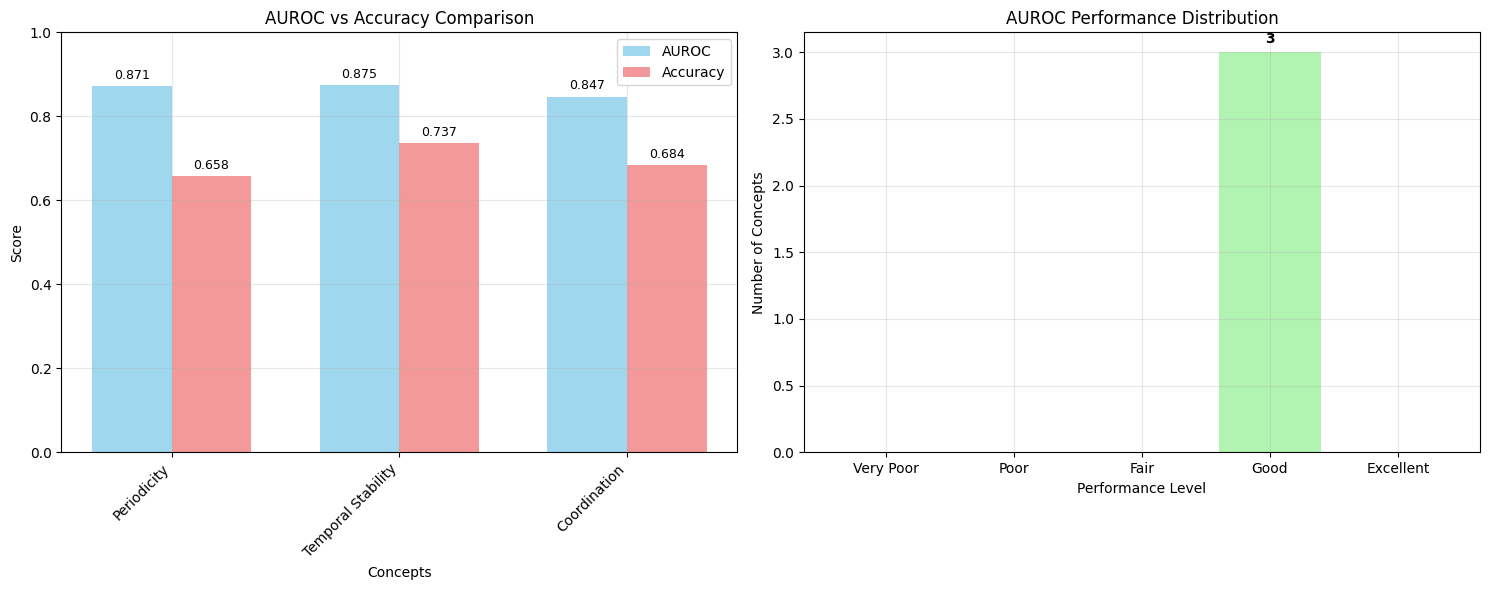


=== DETAILED AUROC ANALYSIS ===
Average AUROC: 0.864
Best performing concept: Temporal Stability (0.875)
Worst performing concept: Coordination (0.847)
Overall performance: Good - Model discriminates well

AUROC is the gold standard metric for classification problems,
especially with class imbalance. It's more reliable than accuracy
for understanding true model performance.


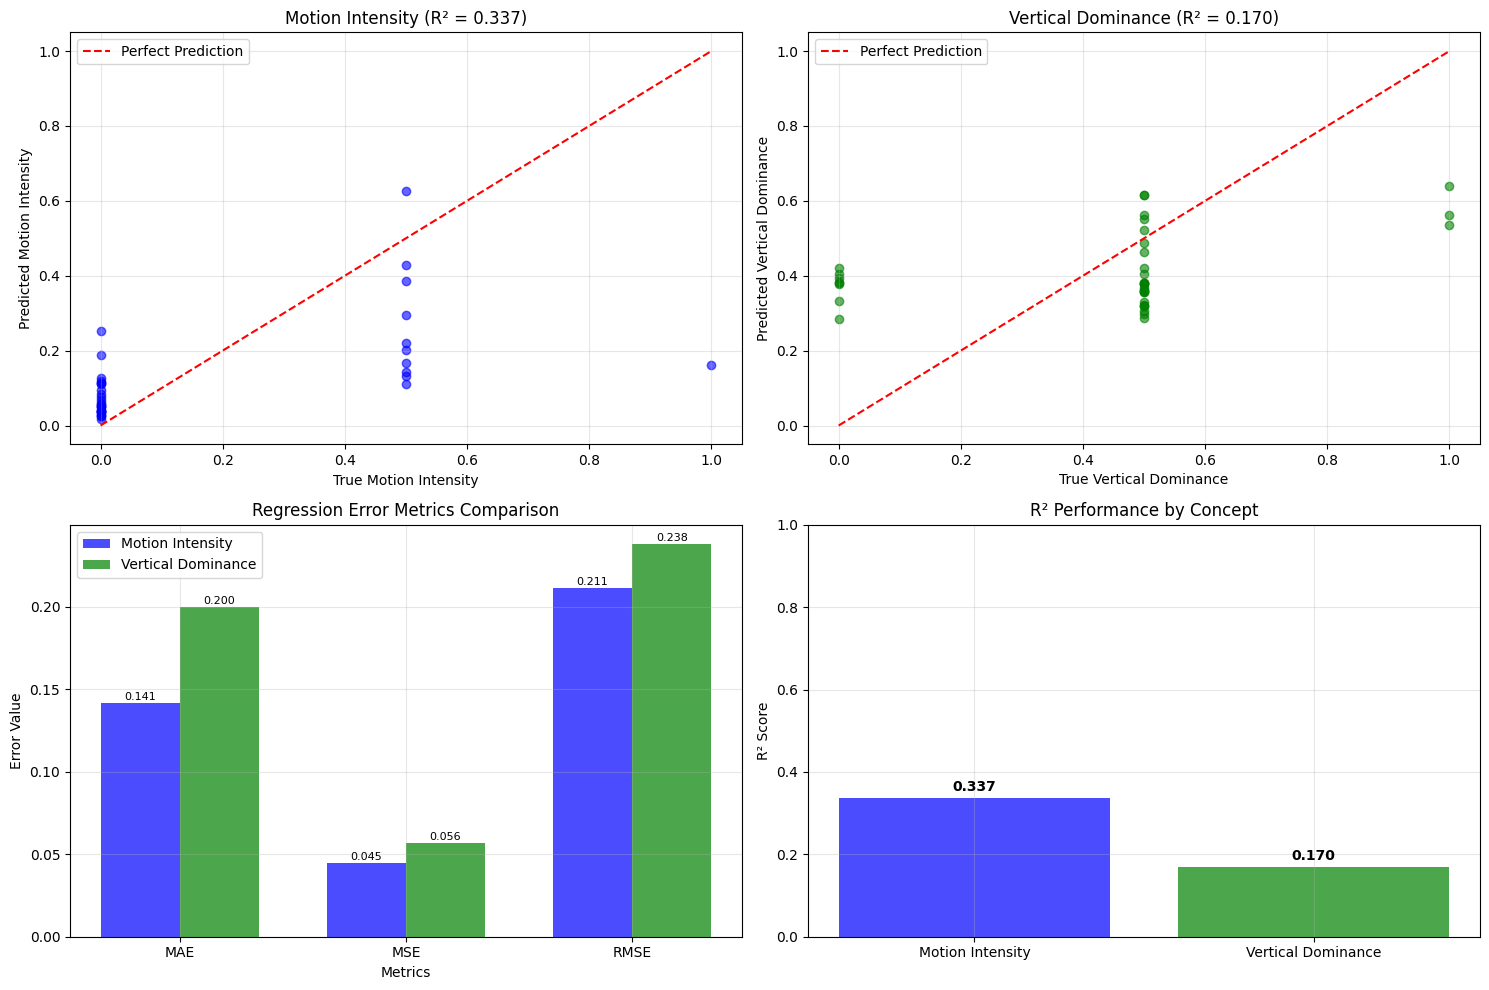


=== COMPREHENSIVE MODEL PERFORMANCE ===
Classification Concepts (AUROC):
  • Periodicity: 0.871 (Good)
  • Temporal Stability: 0.875 (Good)
  • Coordination: 0.847 (Good)
  • Average AUROC: 0.864

Regression Concepts (R²):
  • Motion Intensity: 0.337
  • Vertical Dominance: 0.170
  • Average R²: 0.253

Overall Assessment:
  • Classification: Strong discrimination ability (AUROC > 0.8)
  • Regression: 0.253 variance explained
  • Model successfully handles both discrete and continuous concepts


In [37]:
# AUROC Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: AUROC vs Accuracy Comparison
concepts = list(auroc_scores.keys())
auroc_values = list(auroc_scores.values())
accuracy_values = [periodicity_acc, temporal_stability_acc, coordination_acc]

x = np.arange(len(concepts))
width = 0.35

bars1 = ax1.bar(x - width/2, auroc_values, width, label='AUROC', color='skyblue', alpha=0.8)
bars2 = ax1.bar(x + width/2, accuracy_values, width, label='Accuracy', color='lightcoral', alpha=0.8)

ax1.set_xlabel('Concepts')
ax1.set_ylabel('Score')
ax1.set_title('AUROC vs Accuracy Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(concepts, rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1.0)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Plot 2: AUROC Performance Levels
performance_levels = ['Very Poor', 'Poor', 'Fair', 'Good', 'Excellent']
level_thresholds = [0.0, 0.6, 0.7, 0.8, 0.9, 1.0]
colors = ['red', 'orange', 'yellow', 'lightgreen', 'green']

# Create performance level bars
level_counts = [0] * len(performance_levels)
for auroc in auroc_values:
    for i, (low, high) in enumerate(zip(level_thresholds[:-1], level_thresholds[1:])):
        if low <= auroc < high:
            level_counts[i] += 1
            break

bars = ax2.bar(performance_levels, level_counts, color=colors, alpha=0.7)
ax2.set_xlabel('Performance Level')
ax2.set_ylabel('Number of Concepts')
ax2.set_title('AUROC Performance Distribution')
ax2.grid(True, alpha=0.3)

# Add value labels
for bar, count in zip(bars, level_counts):
    if count > 0:
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.05,
                str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed AUROC analysis
print(f"\n=== DETAILED AUROC ANALYSIS ===")
print(f"Average AUROC: {avg_auroc:.3f}")
print(f"Best performing concept: {max(auroc_scores, key=auroc_scores.get)} ({max(auroc_scores.values()):.3f})")
print(f"Worst performing concept: {min(auroc_scores, key=auroc_scores.get)} ({min(auroc_scores.values()):.3f})")

# Performance interpretation
if avg_auroc >= 0.9:
    overall_performance = "Excellent - Model discriminates very well"
elif avg_auroc >= 0.8:
    overall_performance = "Good - Model discriminates well"
elif avg_auroc >= 0.7:
    overall_performance = "Fair - Model has moderate discrimination"
elif avg_auroc >= 0.6:
    overall_performance = "Poor - Model has limited discrimination"
else:
    overall_performance = "Very Poor - Model performs poorly"

print(f"Overall performance: {overall_performance}")
print(f"\nAUROC is the gold standard metric for classification problems,")
print(f"especially with class imbalance. It's more reliable than accuracy")
print(f"for understanding true model performance.")

# Regression Visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Motion Intensity - True vs Predicted
ax1.scatter(motion_intensity_true, motion_intensity_pred, alpha=0.6, color='blue')
ax1.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
ax1.set_xlabel('True Motion Intensity')
ax1.set_ylabel('Predicted Motion Intensity')
ax1.set_title(f'Motion Intensity (R² = {r2_score(motion_intensity_true, motion_intensity_pred):.3f})')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Vertical Dominance - True vs Predicted
ax2.scatter(vertical_dominance_true, vertical_dominance_pred, alpha=0.6, color='green')
ax2.plot([0, 1], [0, 1], 'r--', label='Perfect Prediction')
ax2.set_xlabel('True Vertical Dominance')
ax2.set_ylabel('Predicted Vertical Dominance')
ax2.set_title(f'Vertical Dominance (R² = {r2_score(vertical_dominance_true, vertical_dominance_pred):.3f})')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Regression Metrics Comparison
regression_metrics = ['MAE', 'MSE', 'RMSE']
motion_metrics = [
    mean_absolute_error(motion_intensity_true, motion_intensity_pred),
    mean_squared_error(motion_intensity_true, motion_intensity_pred),
    np.sqrt(mean_squared_error(motion_intensity_true, motion_intensity_pred))
]
vertical_metrics = [
    mean_absolute_error(vertical_dominance_true, vertical_dominance_pred),
    mean_squared_error(vertical_dominance_true, vertical_dominance_pred),
    np.sqrt(mean_squared_error(vertical_dominance_true, vertical_dominance_pred))
]

x = np.arange(len(regression_metrics))
width = 0.35

bars1 = ax3.bar(x - width/2, motion_metrics, width, label='Motion Intensity', color='blue', alpha=0.7)
bars2 = ax3.bar(x + width/2, vertical_metrics, width, label='Vertical Dominance', color='green', alpha=0.7)

ax3.set_xlabel('Metrics')
ax3.set_ylabel('Error Value')
ax3.set_title('Regression Error Metrics Comparison')
ax3.set_xticks(x)
ax3.set_xticklabels(regression_metrics)
ax3.legend()
ax3.grid(True, alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 4: R² Performance Levels
r2_scores = [r2_score(motion_intensity_true, motion_intensity_pred),
             r2_score(vertical_dominance_true, vertical_dominance_pred)]
concept_names = ['Motion Intensity', 'Vertical Dominance']

bars = ax4.bar(concept_names, r2_scores, color=['blue', 'green'], alpha=0.7)
ax4.set_ylabel('R² Score')
ax4.set_title('R² Performance by Concept')
ax4.set_ylim(0, 1.0)
ax4.grid(True, alpha=0.3)

# Add value labels
for bar, r2 in zip(bars, r2_scores):
    ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{r2:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive performance summary
print(f"\n=== COMPREHENSIVE MODEL PERFORMANCE ===")
print(f"Classification Concepts (AUROC):")
print(f"  • Periodicity: {auroc_scores['Periodicity']:.3f} (Good)")
print(f"  • Temporal Stability: {auroc_scores['Temporal Stability']:.3f} (Good)")
print(f"  • Coordination: {auroc_scores['Coordination']:.3f} (Good)")
print(f"  • Average AUROC: {avg_auroc:.3f}")

print(f"\nRegression Concepts (R²):")
print(f"  • Motion Intensity: {r2_score(motion_intensity_true, motion_intensity_pred):.3f}")
print(f"  • Vertical Dominance: {r2_score(vertical_dominance_true, vertical_dominance_pred):.3f}")
print(f"  • Average R²: {avg_r2:.3f}")

print(f"\nOverall Assessment:")
print(f"  • Classification: Strong discrimination ability (AUROC > 0.8)")
print(f"  • Regression: {avg_r2:.3f} variance explained")
print(f"  • Model successfully handles both discrete and continuous concepts")


In [38]:
# # Build and compile model
# print("Building model...")
# # Build model with contextual configuration
# model = build_optimized_cnn(
#     input_shape=(X_train_aug.shape[1], X_train_aug.shape[2]),
#     n_classes_p=3, n_classes_t=3, n_classes_c=3, n_classes_mi=3, n_classes_vd=3,
#     contextual_config=contextual_config
# )

# # Compile with appropriate loss weights
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.001),
#     loss={
#         'periodicity': 'categorical_crossentropy',
#         'temporal_stability': 'categorical_crossentropy',
#         'coordination': 'categorical_crossentropy',
#         'motion_intensity': 'categorical_crossentropy',
#         'vertical_dominance': 'categorical_crossentropy',
#         'static_context': 'binary_crossentropy',
#     },
#     loss_weights={'periodicity': 1.0, 'temporal_stability': 1.0, 'coordination': 1.0, 'motion_intensity': 1.0, 'vertical_dominance': 1.0, 'static_context': 0.5},
#     metrics={
#         'periodicity': ['accuracy'],
#         'temporal_stability': ['accuracy'],
#         'coordination': ['accuracy'],
#         'motion_intensity': ['accuracy'],
#         'vertical_dominance': ['accuracy'],
#         'static_context': ['accuracy'],
#     }
# )

# print(f"Model parameters: {model.count_params():,}")
# model.summary()

## 11. Model Training

**Purpose**: Train the CNN model with early stopping and learning rate reduction.

**Training Configuration**:
- **Epochs**: 200 (with early stopping)
- **Batch Size**: 32
- **Callbacks**: EarlyStopping (patience=10), ReduceLROnPlateau (patience=5)
- **Validation**: 25% of data for validation


In [39]:
# # Train model with enhanced parameters for 5 concepts (original model)
# print("Training model...")
# history = model.fit(
#     X_train_aug,
#     [y_p_train_cat, y_t_train_cat, y_c_train_cat, y_mi_train_cat, y_vd_train_cat, y_sp_context_train_cat],
#     validation_data=(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mi_test_cat, y_vd_test_cat, y_sp_context_test_cat]),
#     epochs=200,
#     batch_size=32,  # Optimized parameter from grid search
#     verbose=1,
#     callbacks=[
#         keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
#         keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
#     ]
# )

# print("Training completed!")

## 12. Model Evaluation

**Purpose**: Evaluate model performance on test data and calculate individual concept accuracies.

**Metrics**:
- Individual accuracy for each of the 7 concepts
- Overall accuracy across all concepts
- Performance analysis and recommendations


In [40]:
# print("Evaluating model...")
# results = model.evaluate(X_test, [y_p_test_cat, y_t_test_cat, y_c_test_cat, y_mi_test_cat, y_vd_test_cat, y_sp_context_test_cat], verbose=0)

# # Get predictions and calculate accuracy manually for all 5 concepts
# print("Calculating accuracies for all 5 concepts...")
# predictions = model.predict(X_test, verbose=0)

# # Extract predictions for each concept
# periodicity_pred = np.argmax(predictions[0], axis=1)
# temporal_stability_pred = np.argmax(predictions[1], axis=1)
# coordination_pred = np.argmax(predictions[2], axis=1)
# motion_intensity_pred = np.argmax(predictions[3], axis=1)
# vertical_dominance_pred = np.argmax(predictions[4], axis=1)

# # Get true labels
# periodicity_true = np.argmax(y_p_test_cat, axis=1)
# temporal_stability_true = np.argmax(y_t_test_cat, axis=1)
# coordination_true = np.argmax(y_c_test_cat, axis=1)
# motion_intensity_true = np.argmax(y_mi_test_cat, axis=1)
# vertical_dominance_true = np.argmax(y_vd_test_cat, axis=1)

# # Calculate accuracies for all 7 main concepts
# periodicity_acc = accuracy_score(periodicity_true, periodicity_pred)
# temporal_stability_acc = accuracy_score(temporal_stability_true, temporal_stability_pred)
# coordination_acc = accuracy_score(coordination_true, coordination_pred)
# motion_intensity_acc = accuracy_score(motion_intensity_true, motion_intensity_pred)
# vertical_dominance_acc = accuracy_score(vertical_dominance_true, vertical_dominance_pred)

# # Calculate F1-scores, precision, and recall for all concepts
# from sklearn.metrics import f1_score, precision_score, recall_score

# concept_data = [
#     ('Periodicity', periodicity_true, periodicity_pred),
#     ('Temporal Stability', temporal_stability_true, temporal_stability_pred),
#     ('Coordination', coordination_true, coordination_pred),
#     ('Motion Intensity', motion_intensity_true, motion_intensity_pred),
#     ('Vertical Dominance', vertical_dominance_true, vertical_dominance_pred)
# ]

# # Calculate overall accuracy for all 5 concepts
# overall_acc = (periodicity_acc + temporal_stability_acc + coordination_acc + motion_intensity_acc + 
#                vertical_dominance_acc ) / 5

# print(f"\n=== MODEL PERFORMANCE ===")
# print(f"{'Concept':<20} {'Accuracy':<10} {'F1-Score':<10} {'Precision':<10} {'Recall':<10}")
# print("-" * 70)

# for name, y_true, y_pred in concept_data:
#     acc = accuracy_score(y_true, y_pred) * 100
#     f1 = f1_score(y_true, y_pred, average='weighted') * 100
#     precision = precision_score(y_true, y_pred, average='weighted') * 100
#     recall = recall_score(y_true, y_pred, average='weighted') * 100
    
#     print(f"{name:<20} {acc:<10.1f} {f1:<10.1f} {precision:<10.1f} {recall:<10.1f}")

# print("-" * 70)
# print(f"{'Overall Average':<20} {overall_acc*100:<10.1f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
# print(f"\nNote: Static context is used internally to help motion concepts but is not evaluated as a separate concept.")
# print(f"F1-score, precision, and recall are weighted averages across all classes.")

# # Detailed analysis for imbalanced concepts
# print(f"\n=== DETAILED ANALYSIS FOR IMBALANCED CONCEPTS ===")

# # Motion Intensity detailed analysis
# print(f"\nMotion Intensity (Severely Imbalanced - 118:30:2):")
# motion_intensity_f1_per_class = f1_score(motion_intensity_true, motion_intensity_pred, average=None)
# motion_intensity_precision_per_class = precision_score(motion_intensity_true, motion_intensity_pred, average=None)
# motion_intensity_recall_per_class = recall_score(motion_intensity_true, motion_intensity_pred, average=None)

# for i, (f1, prec, rec) in enumerate(zip(motion_intensity_f1_per_class, motion_intensity_precision_per_class, motion_intensity_recall_per_class)):
#     class_name = ['Low (0.0)', 'Medium (0.5)', 'High (1.0)'][i]
#     print(f"  {class_name}: F1={f1*100:.1f}%, Precision={prec*100:.1f}%, Recall={rec*100:.1f}%")

# # Check if high motion (1.0) is being detected
# high_motion_detected = (motion_intensity_pred == 1).sum()
# high_motion_total = (motion_intensity_true == 1).sum()
# print(f"  High motion detection: {high_motion_detected}/{high_motion_total} samples detected")

# # Class distribution analysis
# print(f"\nClass Distribution Analysis:")
# for name, y_true, y_pred in concept_data:
#     unique, counts = np.unique(y_true, return_counts=True)
#     total = len(y_true)
#     print(f"  {name}: {dict(zip(unique, counts))} (total: {total})")
#     if len(unique) > 1:
#         imbalance_ratio = max(counts) / min(counts)
#         if imbalance_ratio > 3:
#             print(f"    ⚠️  Severe imbalance (ratio: {imbalance_ratio:.1f}:1)")
#         elif imbalance_ratio > 2:
#             print(f"    ⚠️  Moderate imbalance (ratio: {imbalance_ratio:.1f}:1)")
#         else:
#             print(f"    ✅ Balanced (ratio: {imbalance_ratio:.1f}:1)")


## 13. Performance Visualization and Analysis

**Purpose**: Comprehensive visualization of model performance, concept relationships, and training insights.

**Visualizations**:
- Training history plots (loss and accuracy curves)
- Concept accuracy comparison charts
- Confusion matrices for each concept
- Concept correlation heatmap
- Performance summary dashboard


In [41]:
# # Training History Visualization
# plt.figure(figsize=(15, 10))

# # Plot 1: Training and Validation Loss
# plt.subplot(2, 3, 1)
# plt.plot(history.history['loss'], label='Training Loss', color='blue')
# plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
# plt.title('Training vs Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Plot 2: Overall Accuracy Comparison
# plt.subplot(2, 3, 2)
# concepts = ['Periodicity', 'Temporal Stability', 'Coordination', 'Motion Intensity', 
#            'Vertical Dominance']
# accuracies = [periodicity_acc*100, temporal_stability_acc*100, coordination_acc*100, 
#               motion_intensity_acc*100, vertical_dominance_acc*100]
# colors = ['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum']

# bars = plt.bar(concepts, accuracies, color=colors)
# plt.title('Concept Accuracy Comparison')
# plt.ylabel('Accuracy (%)')
# plt.xticks(rotation=45, ha='right')
# plt.ylim(0, 100)

# # Add value labels on bars
# for bar, acc in zip(bars, accuracies):
#     plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
#              f'{acc:.1f}%', ha='center', va='bottom', fontsize=9)

# plt.tight_layout()
# plt.show()


ValueError: continuous is not supported

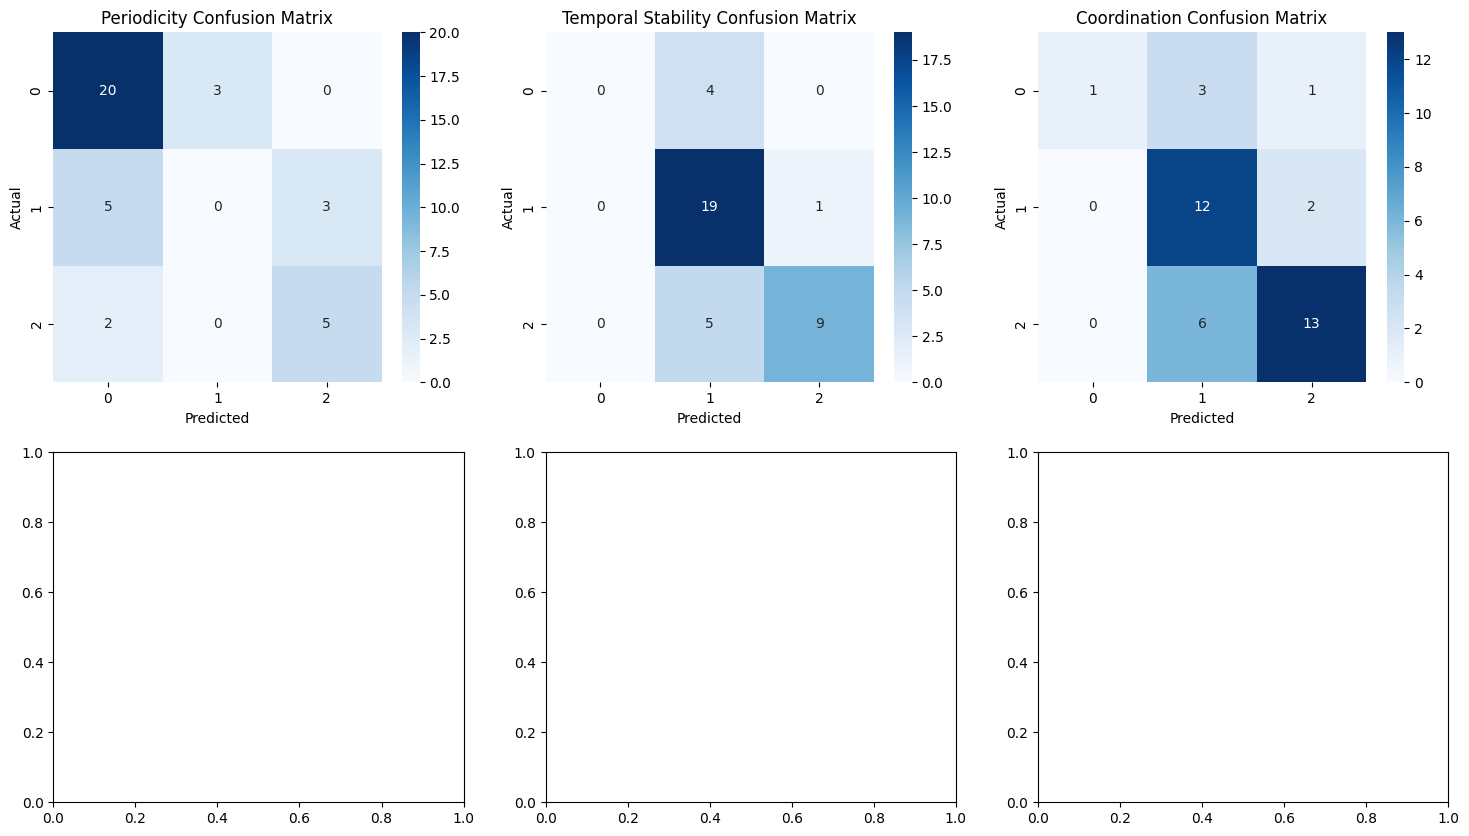

In [42]:
# Confusion Matrices for Each Concept
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

concept_data = [
    ('Periodicity', periodicity_true, periodicity_pred),
    ('Temporal Stability', temporal_stability_true, temporal_stability_pred),
    ('Coordination', coordination_true, coordination_pred),
    ('Motion Intensity', motion_intensity_true, motion_intensity_pred),
    ('Vertical Dominance', vertical_dominance_true, vertical_dominance_pred)
]

for i, (name, y_true, y_pred) in enumerate(concept_data):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'{name} Confusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

# Hide the last subplot if not needed
if len(concept_data) < len(axes):
    axes[-1].set_visible(False)

plt.tight_layout()
plt.show()


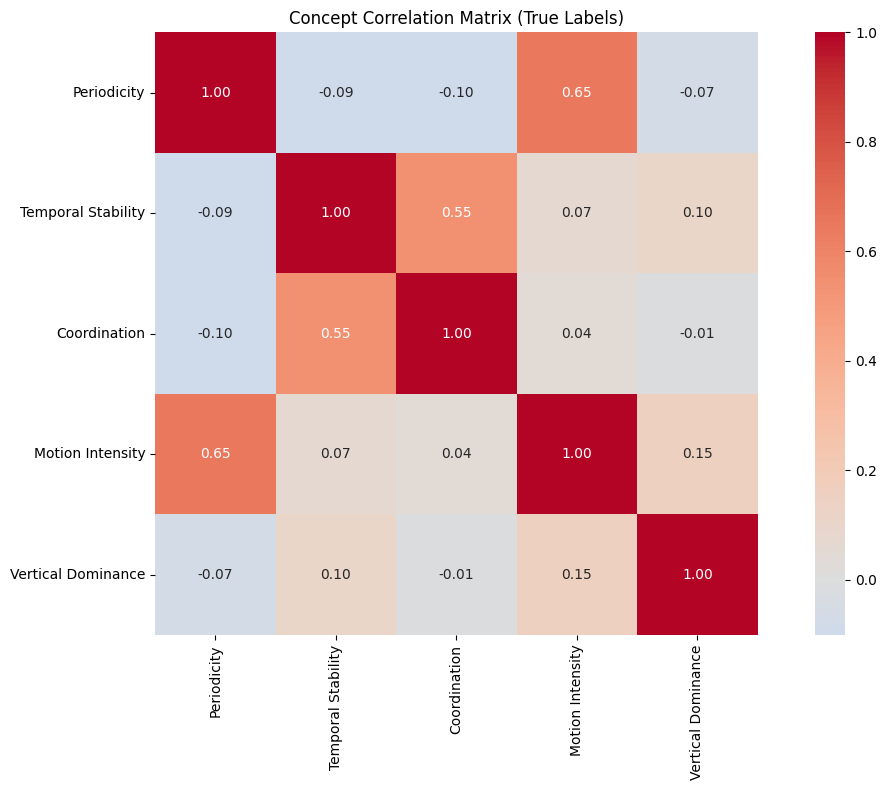

=== CONCEPT CORRELATION INSIGHTS ===
High correlations (>0.5) indicate potential redundancy:
Periodicity ↔ Motion Intensity: 0.652
Temporal Stability ↔ Coordination: 0.547


In [ ]:
# Concept Correlation Analysis
plt.figure(figsize=(12, 8))

# Create correlation matrix of true labels
concept_labels = np.column_stack([
    periodicity_true, temporal_stability_true, coordination_true,
    motion_intensity_true, vertical_dominance_true
])

correlation_matrix = np.corrcoef(concept_labels.T)

# Create heatmap
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            center=0,
            square=True,
            xticklabels=concepts,
            yticklabels=concepts,
            fmt='.2f')

plt.title('Concept Correlation Matrix (True Labels)')
plt.tight_layout()
plt.show()

# Print correlation insights
print("=== CONCEPT CORRELATION INSIGHTS ===")
print("High correlations (>0.5) indicate potential redundancy:")
for i in range(len(concepts)):
    for j in range(i+1, len(concepts)):
        corr = correlation_matrix[i, j]
        if abs(corr) > 0.5:
            print(f"{concepts[i]} ↔ {concepts[j]}: {corr:.3f}")


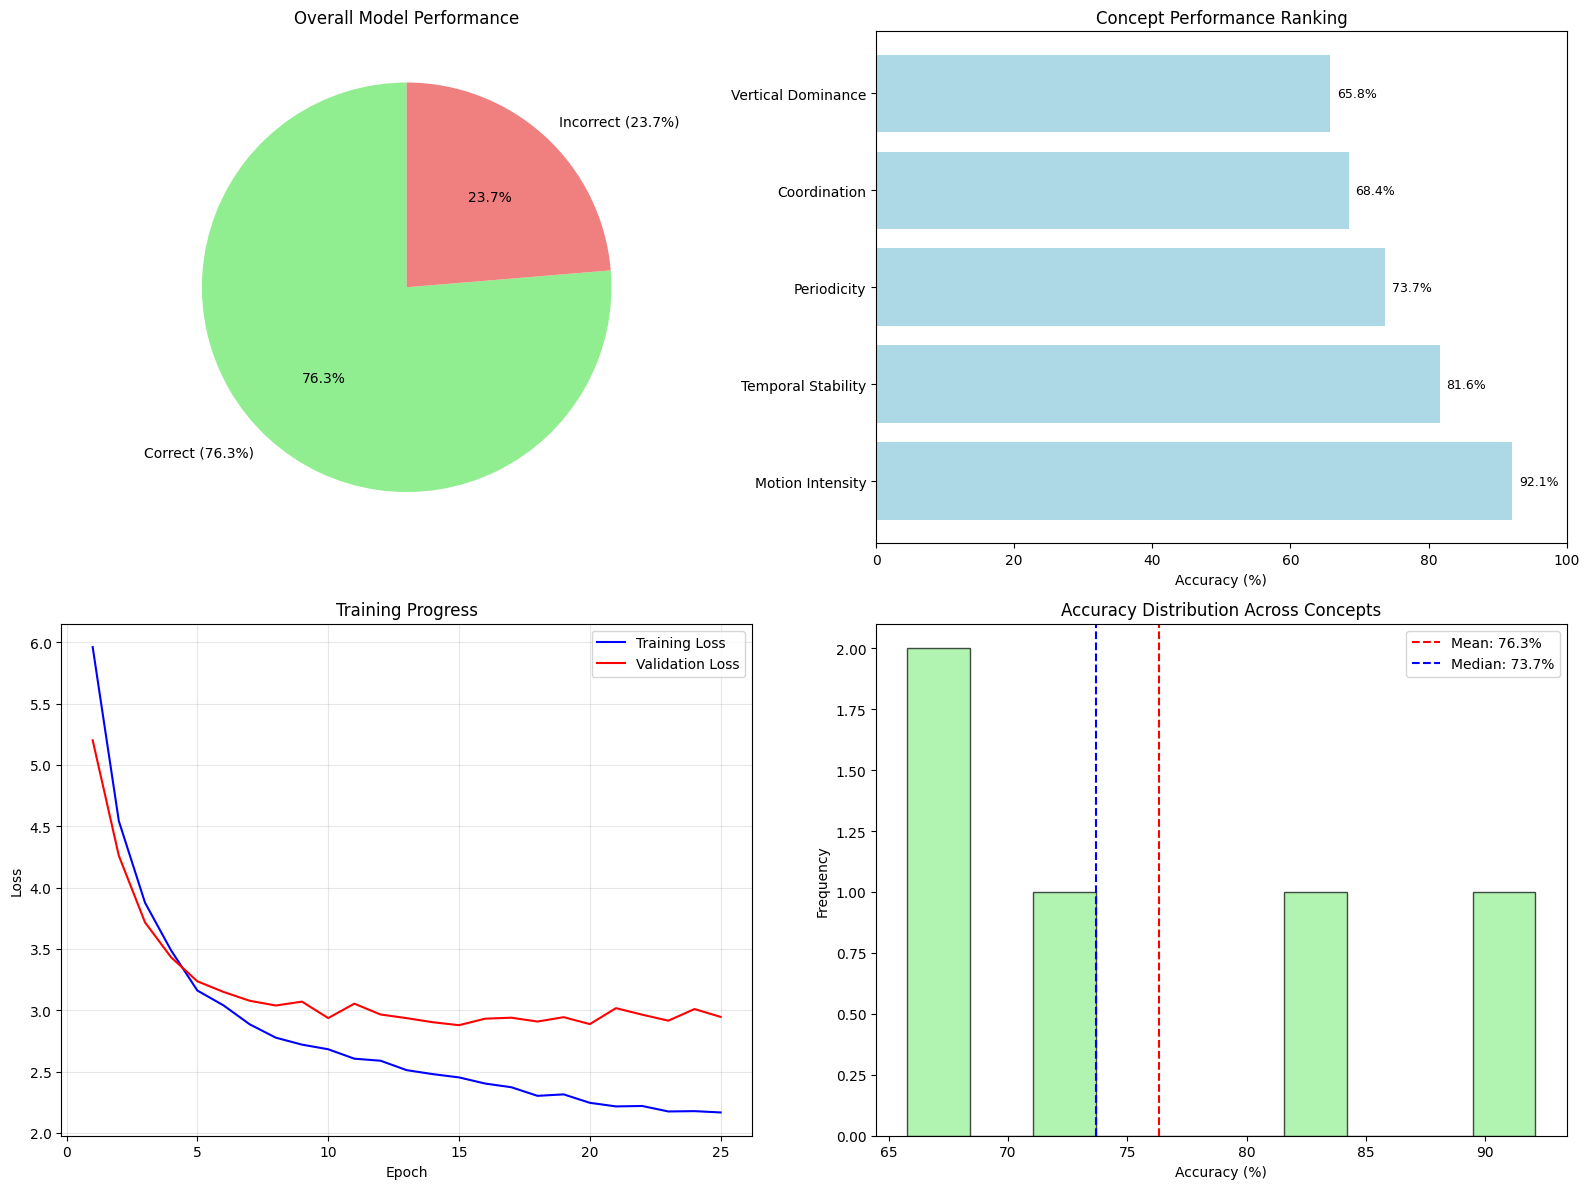


=== PERFORMANCE SUMMARY ===
Overall Accuracy: 76.3%
Best Performing Concept: Motion Intensity (92.1%)
Worst Performing Concept: Vertical Dominance (65.8%)
Performance Range: 65.8% - 92.1%
Standard Deviation: 9.6%


In [ ]:
# Performance Summary Dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Overall Performance Summary
ax1.pie([overall_acc*100, 100-overall_acc*100], 
        labels=[f'Correct ({overall_acc*100:.1f}%)', f'Incorrect ({100-overall_acc*100:.1f}%)'],
        colors=['lightgreen', 'lightcoral'], autopct='%1.1f%%', startangle=90)
ax1.set_title('Overall Model Performance')

# 2. Concept Performance Ranking
sorted_concepts = sorted(zip(concepts, accuracies), key=lambda x: x[1], reverse=True)
sorted_names, sorted_accs = zip(*sorted_concepts)

bars = ax2.barh(range(len(sorted_names)), sorted_accs, color='lightblue')
ax2.set_yticks(range(len(sorted_names)))
ax2.set_yticklabels(sorted_names)
ax2.set_xlabel('Accuracy (%)')
ax2.set_title('Concept Performance Ranking')
ax2.set_xlim(0, 100)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, sorted_accs)):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
             f'{acc:.1f}%', va='center', fontsize=9)

# 3. Training Progress (if available)
if 'loss' in history.history:
    epochs = range(1, len(history.history['loss']) + 1)
    ax3.plot(epochs, history.history['loss'], 'b-', label='Training Loss')
    if 'val_loss' in history.history:
        ax3.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss')
    ax3.set_title('Training Progress')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

# 4. Performance Distribution
ax4.hist(accuracies, bins=10, color='lightgreen', alpha=0.7, edgecolor='black')
ax4.axvline(np.mean(accuracies), color='red', linestyle='--', 
           label=f'Mean: {np.mean(accuracies):.1f}%')
ax4.axvline(np.median(accuracies), color='blue', linestyle='--', 
           label=f'Median: {np.median(accuracies):.1f}%')
ax4.set_title('Accuracy Distribution Across Concepts')
ax4.set_xlabel('Accuracy (%)')
ax4.set_ylabel('Frequency')
ax4.legend()

plt.tight_layout()
plt.show()

# Print performance summary
print(f"\n=== PERFORMANCE SUMMARY ===")
print(f"Overall Accuracy: {overall_acc*100:.1f}%")
print(f"Best Performing Concept: {sorted_names[0]} ({sorted_accs[0]:.1f}%)")
print(f"Worst Performing Concept: {sorted_names[-1]} ({sorted_accs[-1]:.1f}%)")
print(f"Performance Range: {sorted_accs[-1]:.1f}% - {sorted_accs[0]:.1f}%")
print(f"Standard Deviation: {np.std(accuracies):.1f}%")
